<a href="https://colab.research.google.com/github/Rahulx911/Defect-Detection/blob/main/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.applications import Xception,VGG19,ResNet50,InceptionResNetV2,ResNet152V2,EfficientNetB2,ConvNeXtTiny
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout
random.seed(555)

In [ ]:
from google.colab import drive
import zipfile
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dir_train = '/content/drive/MyDrive/unzipped_files/casting_data/test'
dir_test = '/content/drive/MyDrive/unzipped_files/casting_data/train'

In [ ]:
# Train
dir_train_def = dir_train + '/def_front/'
dir_train_ok = dir_train + '/ok_front/'
# Test
dir_test_def = dir_test + '/def_front/'
dir_test_ok = dir_test + '/ok_front/'

In [ ]:
image_files_train_def = os.listdir(dir_train_def)
image_files_train_ok = os.listdir(dir_train_ok)

In [ ]:
n = len(image_files_train_def)
m = len(image_files_train_ok)
print(f'the number of all the images in the training set is {n+m}')
print(f'number of def imgs is {n}')
print(f'number of ok imgs is {m}')
print(f'the ratio between ok and def imgs is {m/n}')


the number of all the images in the training set is 714
number of def imgs is 452
number of ok imgs is 262
the ratio between ok and def imgs is 0.5796460176991151


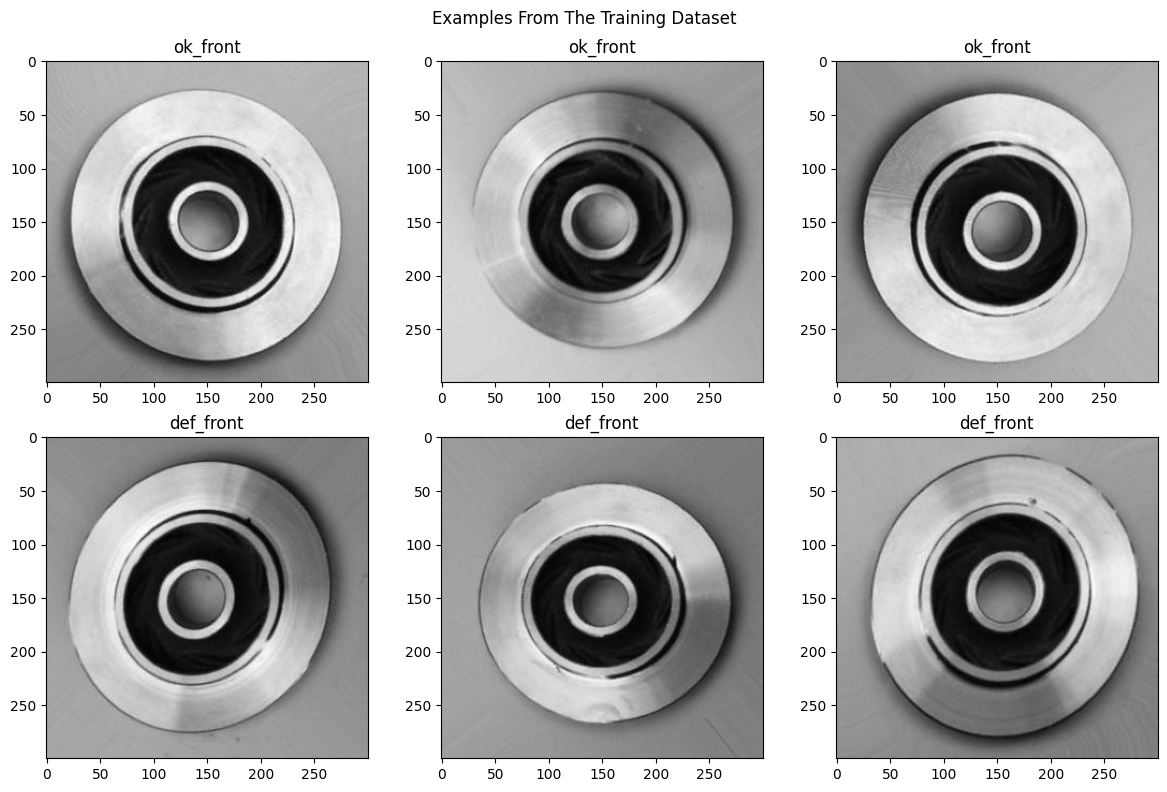

In [ ]:
# Function to get a list of random image files from a directory
def get_random_image_files(directory, num_files):
    files = os.listdir(directory)
    random.shuffle(files)
    return files[:num_files]

# Create a 2x3 grid for "ok_front" images
plt.figure(figsize=(12, 8))
plt.suptitle('Examples From The Training Dataset')

for i in range(3):
    plt.subplot(2, 3, i + 1)
    image_files_ok = get_random_image_files(dir_train_ok, 3)
    img = Image.open(os.path.join(dir_train_ok, image_files_ok[i]))
    plt.imshow(img)
    plt.title('ok_front')

# Create a 2x3 grid for "def_front" images
for i in range(3):
    plt.subplot(2, 3, i + 4)
    image_files_def = get_random_image_files(dir_train_def, 3)
    img = Image.open(os.path.join(dir_train_def, image_files_def[i]))
    plt.imshow(img)
    plt.title('def_front')

plt.tight_layout()
plt.show()

In [ ]:
# same for the ok_front
img = Image.open(os.path.join(dir_train_def, image_files_def[0]))
img.size, img.mode

((300, 300), 'RGB')

In [ ]:
# We can observe that we can generate more examples just using rotations
img_size = (300,300)
rand_seed = 555
batch_size = 16
epochs = 15

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    brightness_range=[0.2, 1.5],
    validation_split=0.4,
)

test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}

arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}
# 80%
train_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='training',
                                          **arg_train)
#20%
valid_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='validation',
                                          **arg_train)

# for the 0 and 1 ...etc
test_set = test_gen.flow_from_directory(directory=dir_test,
                                        **arg_test)

Found 430 images belonging to 2 classes.
Found 284 images belonging to 2 classes.
Found 6633 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import PIL

def validate_image(path):
    try:
        img = PIL.Image.open(path)
        img.verify()  # Verify that it is, indeed, an image
        return True
    except (IOError, SyntaxError, PIL.UnidentifiedImageError):
        return False

def create_filtered_image_generator(directory, target_size=(224, 224), batch_size=32, class_mode='binary'):
    datagen = ImageDataGenerator(rescale=1.0/255)

    # Filter out invalid image paths
    valid_file_paths = [
        file_path for file_path in tf.io.gfile.listdir(directory)
        if validate_image(tf.io.gfile.join(directory, file_path))
    ]

    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=True
    )
    return generator


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np
import os

def safe_image_loader(file_path, target_size=(224, 224)):
    try:
        img = load_img(file_path, target_size=target_size)
        return img_to_array(img)
    except Exception as e:
        print(f"Warning: Unable to load image {file_path}. Skipping. Error: {e}")
        return None

# Custom ImageDataGenerator with handling for corrupt images
def custom_data_generator(directory, target_size=(224, 224), batch_size=32, class_mode='binary'):
    datagen = ImageDataGenerator(rescale=1.0 / 255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

    while True:
        x_batch, y_batch = next(generator)
        x_batch_cleaned = []
        y_batch_cleaned = []

        for i in range(len(x_batch)):
            img_array = safe_image_loader(generator.filepaths[generator.index_array[i]])
            if img_array is not None:
                x_batch_cleaned.append(img_array)
                y_batch_cleaned.append(y_batch[i])

        yield np.array(x_batch_cleaned), np.array(y_batch_cleaned)

# Usage:
train_generator = custom_data_generator(dir_train, target_size=(224, 224), batch_size=32)
test_generator = custom_data_generator(dir_test, target_size=(224, 224), batch_size=32)


In [ ]:
from PIL import Image
import os
import shutil

def filter_corrupt_images(directory):
    """
    Scans a directory and removes corrupt or unreadable images.

    Parameters:
        directory (str): Path to the directory containing images.

    Returns:
        int: Number of corrupt images found and removed.
    """
    corrupt_count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Attempt to open the image
                with Image.open(file_path) as img:
                    img.verify()  # Verify that it is an image
            except (IOError, SyntaxError) as e:
                print(f"Corrupt image detected and removed: {file_path}")
                os.remove(file_path)  # Remove the corrupt image
                corrupt_count += 1
    return corrupt_count

# Example usage
train_dir = '/content/drive/MyDrive/unzipped_files/casting_data/train'
test_dir = '/content/drive/MyDrive/unzipped_files/casting_data/test'

# Filter corrupt images in each directory
print("Checking train directory for corrupt images...")
train_corrupt_count = filter_corrupt_images(train_dir)
print(f"Total corrupt images removed from train set: {train_corrupt_count}")

print("Checking test directory for corrupt images...")
test_corrupt_count = filter_corrupt_images(test_dir)
print(f"Total corrupt images removed from test set: {test_corrupt_count}")


Checking train directory for corrupt images...
Total corrupt images removed from train set: 0
Checking test directory for corrupt images...
Total corrupt images removed from test set: 0


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def verify_image_paths(directory):
    """
    Verifies that all image paths in a directory are accessible.
    Any missing image paths are reported.

    Parameters:
        directory (str): Path to the directory containing images.

    Returns:
        int: Number of missing images detected.
    """
    missing_count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not os.path.exists(file_path):
                print(f"Missing file detected: {file_path}")
                missing_count += 1
    return missing_count

# Example usage:
train_dir = '/content/drive/MyDrive/unzipped_files/casting_data/train'
test_dir = '/content/drive/MyDrive/unzipped_files/casting_data/test'

print("Verifying train directory...")
train_missing = verify_image_paths(train_dir)
print(f"Total missing images in train set: {train_missing}")

print("Verifying test directory...")
test_missing = verify_image_paths(test_dir)
print(f"Total missing images in test set: {test_missing}")


Verifying train directory...
Total missing images in train set: 0
Verifying test directory...
Total missing images in test set: 0


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np

def safe_image_loader(file_path, target_size=(224, 224)):
    try:
        # Attempt to load image
        img = load_img(file_path, target_size=target_size)
        return img_to_array(img)
    except (FileNotFoundError, IOError) as e:
        print(f"Missing or corrupt image detected and skipped: {file_path}")
        return None

def custom_data_generator(directory, target_size=(224, 224), batch_size=32, class_mode='binary'):
    datagen = ImageDataGenerator(rescale=1.0 / 255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

    while True:
        x_batch, y_batch = next(generator)
        x_batch_cleaned = []
        y_batch_cleaned = []

        for i in range(len(x_batch)):
            img_array = safe_image_loader(generator.filepaths[generator.index_array[i]])
            if img_array is not None:
                x_batch_cleaned.append(img_array)
                y_batch_cleaned.append(y_batch[i])

        if len(x_batch_cleaned) > 0:
            yield np.array(x_batch_cleaned), np.array(y_batch_cleaned)

# Usage:
train_generator = custom_data_generator('/content/drive/MyDrive/unzipped_files/casting_data/train', target_size=(224, 224), batch_size=32)
test_generator = custom_data_generator('/content/drive/MyDrive/unzipped_files/casting_data/test', target_size=(224, 224), batch_size=32)


In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import Xception, ResNet50, InceptionResNetV2, ResNet152V2
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Enable mixed precision for faster computation if supported
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Safe image loader to skip corrupt or missing files
def safe_image_loader(file_path, target_size=(224, 224)):
    try:
        img = load_img(file_path, target_size=target_size)
        return img_to_array(img)
    except (FileNotFoundError, IOError) as e:
        print(f"Warning: Skipping missing or corrupt image: {file_path}")
        return None

# Custom data generator with error handling for corrupt images
def custom_data_generator(directory, target_size=(224, 224), batch_size=32, class_mode='binary'):
    datagen = ImageDataGenerator(rescale=1.0 / 255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

    while True:
        x_batch, y_batch = next(generator)
        x_batch_cleaned, y_batch_cleaned = [], []

        for i in range(len(x_batch)):
            img_array = safe_image_loader(generator.filepaths[generator.index_array[i]])
            if img_array is not None:
                x_batch_cleaned.append(img_array)
                y_batch_cleaned.append(y_batch[i])

        if x_batch_cleaned:
            yield np.array(x_batch_cleaned), np.array(y_batch_cleaned)

# Calculate steps per epoch
def get_steps_per_epoch(directory, batch_size):
    valid_images = sum([len(files) for r, d, files in os.walk(directory) if files])
    return max(1, valid_images // batch_size)

# Load a pretrained model without top layers
def load_pretrained_model(model_name):
    if model_name == 'Xception':
        return Xception(weights='imagenet', include_top=False)
    elif model_name == 'ResNet50':
        return ResNet50(weights='imagenet', include_top=False)
    elif model_name == 'InceptionResNetV2':
        return InceptionResNetV2(weights='imagenet', include_top=False)
    elif model_name == 'ResNet152V2':
        return ResNet152V2(weights='imagenet', include_top=False)

# Build and compile model
def create_and_compile_model(base_model, learning_rate=0.01):
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2())(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2())(x)
    predictions = Dense(1, activation='sigmoid', dtype='float32')(x)  # Ensure compatibility with mixed precision

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Train and evaluate the model with enhanced logging and batch checks
def train_and_evaluate_model(model, model_name, train_dir, test_dir, epochs=10, batch_size=32):
    model_checkpoint = ModelCheckpoint(
        filepath=f"{model_name}_best_model.weights.h5",
        monitor='accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    )

    # Create data generators
    train_generator = custom_data_generator(train_dir, target_size=(224, 224), batch_size=batch_size)
    test_generator = custom_data_generator(test_dir, target_size=(224, 224), batch_size=batch_size)

    # Calculate steps per epoch
    steps_per_epoch = get_steps_per_epoch(train_dir, batch_size)
    test_steps = get_steps_per_epoch(test_dir, batch_size)

    # Start training timer
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[model_checkpoint]
    )

    # End training timer
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model on the test set
    test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_generator, steps=test_steps)
    evaluation_time = time.time() - end_time

    print(f"\nModel: {model_name}")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Evaluation time: {evaluation_time:.2f} seconds")

    # Collect predictions and ground truth for metrics calculation
    y_true, y_pred = [], []
    for i in range(test_steps):
        x_batch, y_batch = next(test_generator)
        if x_batch.size == 0 or np.isnan(y_batch).any():
            print("Skipping batch due to NaNs or empty data in y_batch")
            continue

        y_pred_batch = model.predict(x_batch)
        if np.isnan(y_pred_batch).any():
            print("Skipping batch due to NaNs in predictions")
            continue

        y_true.extend(y_batch)
        y_pred.extend(y_pred_batch)

    # Ensure valid data for metrics calculation
    if y_true and y_pred:
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_pred_classes = (y_pred > 0.5).astype(int)

        # Compute metrics
        cm = confusion_matrix(y_true, y_pred_classes)
        report = classification_report(y_true, y_pred_classes)
        auc = roc_auc_score(y_true, y_pred)
    else:
        raise ValueError("No valid predictions or labels available for evaluation.")

    return test_acc, cm, report, auc, test_precision, test_recall, history

# Main loop to train multiple models with error handling
model_names = ['Xception', 'InceptionResNetV2', 'ResNet152V2']
results = {}

train_dir = '/content/drive/MyDrive/unzipped_files/casting_data/train'
test_dir = '/content/drive/MyDrive/unzipped_files/casting_data/test'

for model_name in model_names:
    print(f"Training model: {model_name}")
    base_model = load_pretrained_model(model_name)
    model = create_and_compile_model(base_model)

    try:
        # Train and evaluate the model
        test_acc, cm, report, auc, precision, recall, history = train_and_evaluate_model(
            model,
            model_name,
            train_dir,
            test_dir,
            epochs=10,
            batch_size=32
        )

        # Save results
        results[model_name] = {
            'test_accuracy': test_acc,
            'confusion_matrix': cm,
            'classification_report': report,
            'roc_auc': auc,
            'history': history
        }

    except Exception as e:
        print(f"Error occurred while training {model_name}: {e}")
        print("Skipping to the next model...\n")

print("Training complete. All models and weights saved.")


Training model: Xception
Found 6633 images belonging to 2 classes.
Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5212 - auc_8: 0.4935 - loss: 52.6702 - precision_8: 0.4321 - recall_8: 0.3272
Epoch 1: accuracy improved from -inf to 0.52536, saving model to Xception_best_model.weights.h5
207/207 ━━━━━━━━━━━━━━━━━━━━ 46s 178ms/step - accuracy: 0.5213 - auc_8: 0.4935 - loss: 52.4954 - precision_8: 0.4320 - recall_8: 0.3269
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5476 - auc_8: 0.4962 - loss: 0.6939 - precision_8: 0.4078 - recall_8: 0.1583
Epoch 2: accuracy improved from 0.52536 to 0.55537, saving model to Xception_best_model.weights.h5
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.5476 - auc_8: 0.4963 - loss: 0.6939 - precision_8: 0.4080 - recall_8: 0.1581
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5634 - auc_8: 0.5020 - loss: 0.9718 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00
Epoch 3: accuracy impro

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 6633 images belonging to 2 classes.
Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5712 - auc_9: 0.5000 - loss: nan - precision_9: 0.0000e+00 - recall_9: 0.0000e+00
Epoch 1: accuracy improved from -inf to 0.56643, saving model to InceptionResNetV2_best_model.weights.h5
207/207 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.5712 - auc_9: 0.5000 - loss: nan - precision_9: 0.0000e+00 - recall_9: 0.0000e+00
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5783 - auc_9: 0.5000 - loss: nan - precision_9: 0.0000e+00 - recall_9: 0.0000e+00
Epoch 2: accuracy improved from 0.56643 to 0.56719, saving model to InceptionResNetV2_best_model.weights.h5
207/207 ━━━━━━━━━━━━━━━━━━━━ 47s 191ms/step - accuracy: 0.5783 - auc_9: 0.5000 - loss: nan - precision_9: 0.0000e+00 - recall_9: 0.0000e+00
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5699 - auc_9: 0.5000 - loss: nan - precision_9: 0.0000e+00 - recall_9: 0.0000e+00
Epoch 3: accura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Mixed precision for faster computation if supported
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Custom data augmentation with advanced transformations
def custom_data_generator(directory, target_size=(224, 224), batch_size=32, class_mode='binary'):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    return datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

# Calculate steps per epoch
def get_steps_per_epoch(directory, batch_size):
    valid_images = sum([len(files) for r, d, files in os.walk(directory) if files])
    return max(1, valid_images // batch_size)

# Load and fine-tune ResNet152V2 with custom layers
def create_and_compile_model(learning_rate=0.001):
    base_model = ResNet152V2(weights='imagenet', include_top=False)

    # Unfreeze more layers for fine-tuning
    for layer in base_model.layers[-80:]:  # Fine-tune last 80 layers
        layer.trainable = True

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid', dtype='float32')(x)  # Compatibility with mixed precision

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile with a smaller learning rate for fine-tuning
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Train and evaluate the model with improved techniques
def train_and_evaluate_model(model, train_dir, test_dir, epochs=100, batch_size=32):
    model_checkpoint = ModelCheckpoint(
        filepath="ResNet152V2_best_model.weights.h5",
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    )

    # Reduced patience for learning rate scheduling
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,  # Reduced patience
        min_lr=1e-6,
        verbose=1
    )

    # Create data generators with enhanced augmentation for training
    train_generator = custom_data_generator(train_dir, target_size=(224, 224), batch_size=batch_size)
    test_generator = custom_data_generator(test_dir, target_size=(224, 224), batch_size=batch_size)

    # Calculate steps per epoch
    steps_per_epoch = get_steps_per_epoch(train_dir, batch_size)
    test_steps = get_steps_per_epoch(test_dir, batch_size)

    # Start training timer
    start_time = time.time()

    # Train the model with checkpointing and learning rate reduction only
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=test_steps,
        callbacks=[model_checkpoint, reduce_lr]
    )

    # End training timer
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model on the test set
    test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_generator, steps=test_steps)
    evaluation_time = time.time() - end_time

    print(f"\nModel: ResNet152V2")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Evaluation time: {evaluation_time:.2f} seconds")

    # Collect predictions and ground truth for metrics calculation
    y_true, y_pred = [], []
    for i in range(test_steps):
        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)
        y_true.extend(y_batch)
        y_pred.extend(y_pred_batch)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Compute metrics
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes)
    auc = roc_auc_score(y_true, y_pred)

    return test_acc, cm, report, auc, test_precision, test_recall, history

# Training setup
train_dir = '/content/drive/MyDrive/unzipped_files/casting_data/train'
test_dir = '/content/drive/MyDrive/unzipped_files/casting_data/test'

print("Training model: ResNet152V2")
model = create_and_compile_model(learning_rate=0.0001)

# Train and evaluate the model
try:
    test_acc, cm, report, auc, precision, recall, history = train_and_evaluate_model(
        model,
        train_dir,
        test_dir,
        epochs=100,
        batch_size=32
    )

    print("\nTraining complete. Model performance:")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"ROC AUC Score: {auc:.4f}")

except Exception as e:
    print(f"Error occurred during training: {e}")


Training model: ResNet152V2
Found 6633 images belonging to 2 classes.
Found 714 images belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.6148 - auc_13: 0.6746 - loss: 12.1370 - precision_13: 0.5414 - recall_13: 0.6253
Epoch 1: val_accuracy improved from -inf to 0.94602, saving model to ResNet152V2_best_model.weights.h5
207/207 ━━━━━━━━━━━━━━━━━━━━ 373s 944ms/step - accuracy: 0.6154 - auc_13: 0.6753 - loss: 12.1345 - precision_13: 0.5421 - recall_13: 0.6259 - val_accuracy: 0.9460 - val_auc_13: 0.9829 - val_loss: 10.6188 - val_precision_13: 0.9139 - val_recall_13: 0.9421 - learning_rate: 1.0000e-04
Epoch 2/100
  1/207 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 1.0000 - auc_13: 1.0000 - loss: 10.5064 - precision_13: 1.0000 - recall_13: 1.0000

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.94602 to 1.00000, saving model to ResNet152V2_best_model.weights.h5
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 1.0000 - auc_13: 1.0000 - loss: 10.5064 - precision_13: 1.0000 - recall_13: 1.0000 - val_accuracy: 1.0000 - val_auc_13: 1.0000 - val_loss: 10.5123 - val_precision_13: 1.0000 - val_recall_13: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9375 - auc_13: 0.9844 - loss: 10.2917 - precision_13: 0.9197 - recall_13: 0.9391
Epoch 3: val_accuracy did not improve from 1.00000
207/207 ━━━━━━━━━━━━━━━━━━━━ 107s 494ms/step - accuracy: 0.9375 - auc_13: 0.9844 - loss: 10.2900 - precision_13: 0.9198 - recall_13: 0.9392 - val_accuracy: 0.9318 - val_auc_13: 0.9918 - val_loss: 9.2397 - val_precision_13: 0.9607 - val_recall_13: 0.8494 - learning_rate: 1.0000e-04
Epoch 4/100
  1/207 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 1.0000 - auc_13: 1.0000 - loss: 9.1529 - precision_13: 1.0000 -

In [ ]:
# Assuming `model` and `test_generator` are defined and loaded with the test data
y_true, y_pred = [], []
for i in range(get_steps_per_epoch(test_dir, batch_size=32)):
    x_batch, y_batch = next(test_generator)
    y_pred_batch = model.predict(x_batch)
    y_true.extend(y_batch)
    y_pred.extend(y_pred_batch)

# Convert predictions to binary classes based on threshold
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_classes = (y_pred > 0.5).astype(int)


Found 714 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


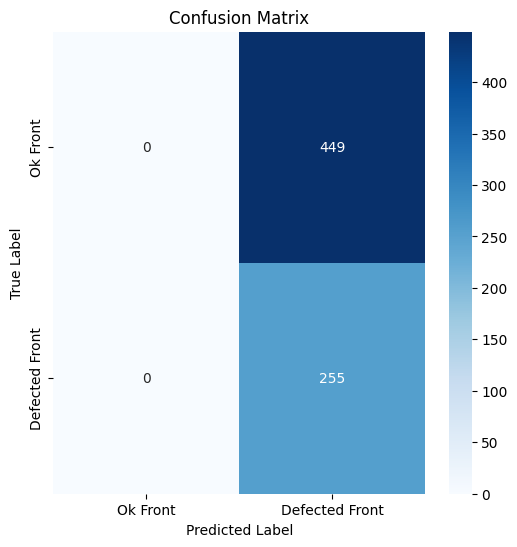

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define labels
class_names = ['Ok Front', 'Defected Front']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


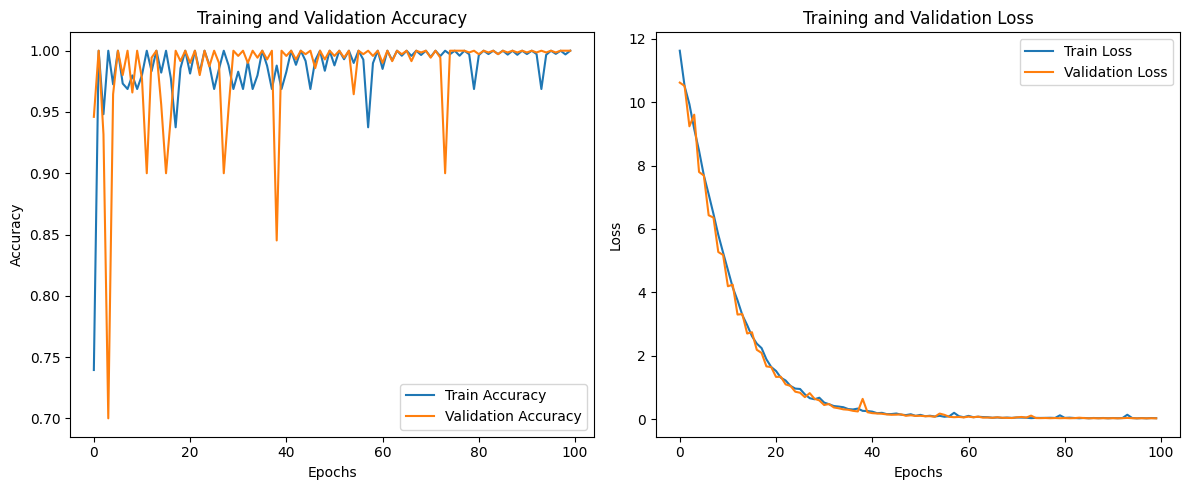

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-44-9c705f66e1fb>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = int(predicted_prob > 0.4)  # Convert probability to binary class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


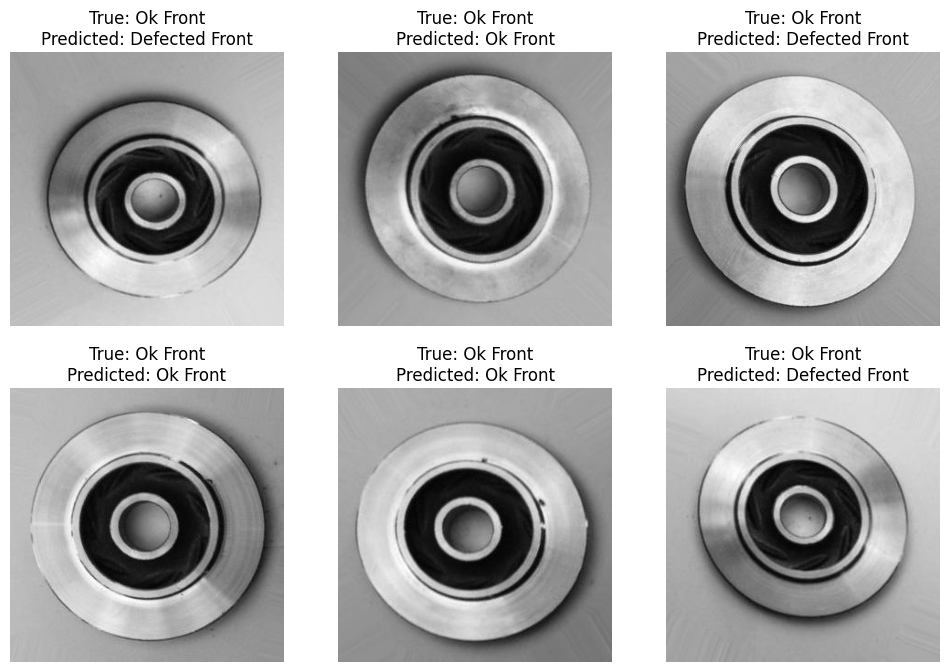

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Parameters for display
num_samples_to_display = 6
nbr_samples_every_row = 3
rows = num_samples_to_display // nbr_samples_every_row
random.seed(33)

# Define the directory structure for test images
test_dir = '/content/drive/MyDrive/unzipped_files/casting_data/test'  # Replace with your test directory path
class_labels = {0: 'Ok Front', 1: 'Defected Front'}  # Mapping of class indices to labels

# Gather all image file paths and corresponding labels
image_paths = []
true_labels = []

for class_dir in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_dir)
    if os.path.isdir(class_path):
        label = 1 if class_dir.lower() == 'defected front' else 0  # Adjust if folder names differ
        for img_file in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_file))
            true_labels.append(label)

# Randomly select a subset of samples
total_samples = len(image_paths)
random_indices = random.sample(range(total_samples), num_samples_to_display)

# Initialize list to store selected images, true labels, and predicted labels
random_sample_data = []

# Load, preprocess images, make predictions, and store results
for idx in random_indices:
    image_path = image_paths[idx]
    true_label = true_labels[idx]
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict label
    predicted_prob = model.predict(img_array)
    predicted_label = int(predicted_prob > 0.4)  # Convert probability to binary class

    # Translate labels for display
    true_label_text = class_labels[true_label]
    predicted_label_text = class_labels[predicted_label]

    # Append data for visualization
    random_sample_data.append((image_path, true_label_text, predicted_label_text))

# Visualize the random sample images with true and predicted labels
plt.figure(figsize=(12, 8))
for i, (image_path, true_label_text, predicted_label_text) in enumerate(random_sample_data):
    img = plt.imread(image_path)
    plt.subplot(rows, nbr_samples_every_row, i + 1)
    plt.imshow(img)
    plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
    plt.axis('off')
plt.show()
